# Natural Language Processings of Bookings.com Hotel Reviews - Preprocessing And Vectorization

Pippi de Bree

## Table of contents
#### [Introduction](#Introduction)

#### [Imports](#Imports)

#### [Sampling](#Sampling)

#### [Binning and Encoding](#Bins)
- [Numeric Variables](#nums)
- [Non-Numeric Variabes](#cats)
- [Executing Variable Alterations](#alts)


#### [Splitting into Training and Testing Sets](#Splitting)

#### [Review Vectorisation](#Vect)
- [Positive Review](#pos)
- [Negative Review](#neg)
- [Combining Matrices](#combo)

#### [Conclusion](#Conclusion)

# Introduction <a id=Introduction a>

In this notebook we will begin readying our data for making predictions on whether a reviewer scored a hotel well. The data contains various forms that will be altered to enable encoding. We will explore options for making categorical data usable in common classification models by looking at encoding categorical variables and vectorising reviews and tags. 

# Imports <a id=Imports a>

In order to perform analysis of the data, we need to have tools that allow us the best functionality when working with a `.csv` file. Below we import some standard libraries that allow us to work more easily with the format of the data and perform statistical analysis.

We also import `ds_utils.py` and `hotel_nlp.py` with functions that are used throughout this analysis. Their uses are explained here but there is more detailed explainations in the files, located in the current directory.

In [74]:
# pandas and numpy are used for data format, for easier manipulation.
import pandas as pd
import numpy as np

In [75]:
# seaborn and variables matplotlib packages are used for visualiations.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [76]:
# Here I am importing my personal library of data science tools and functions
import ds_utils
import hotel_nlp

## Data Import 
We will import the `Hotel_Reviews_Clean.csv` file, as created in the `1_EDA.ipynb` notebook. Using the `read_csv_pd` function from the `ds_utils` package will ensure that the cleanliness of the data can be checked. 

In [77]:
hr_clean = ds_utils.read_csv_pd('data/Hotel_Reviews_Clean.csv')

The DataFrame contains 511944 rows and 18 columns.
There are 0 missing values and 0 duplicated rows.


In [78]:
hr_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511944 entries, 0 to 511943
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               511944 non-null  object 
 1   Additional_Number_of_Scoring                511944 non-null  int64  
 2   Review_Date                                 511944 non-null  object 
 3   Average_Score                               511944 non-null  float64
 4   Hotel_Name                                  511944 non-null  object 
 5   Reviewer_Nationality                        511944 non-null  object 
 6   Negative_Review                             511944 non-null  object 
 7   Review_Total_Negative_Word_Counts           511944 non-null  int64  
 8   Total_Number_of_Reviews                     511944 non-null  int64  
 9   Positive_Review                             511944 non-null  object 
 

The data has been successfully read it, as it takes the same form as in the EDA. 

# Sampling <a id=Sampling a>

We can now ready our data for modelling. Before we do this we will make a sample of our data to work with, but, as mentioned, there is a serious skew in our data. Therefore we will need to ensure that the sample we create is representative of all of the possible review scores. About 10% of the data is 52,000. 

As we know there is a skew, we are most likely going to resample our training data. Because of this, we will take a sample that is larger than 10% because we will loose some data in downsampling. At this point we will take a sample size of about 0.11%

In [79]:
hr_samp = hr_clean.sample(frac=0.11, random_state=11).reset_index(drop=True)

Eventhough we already have our `good_review` columns, we want to check that the original classes are represente. A value count of `Reviewer_Score` will show us the classes in the sample.

In [80]:
hr_samp[['Reviewer_Score']].value_counts()

Reviewer_Score
10                20325
8                 11915
9                 11771
7                  4883
6                  3048
5                  2648
4                  1006
3                   718
dtype: int64

From this we can see that all rating classes are represented. It is helpful at this point to look at the dsitribution of `good_review`, to see how skewed our sample is with this new dependent variable.

In [81]:
hr_samp['good_review'].value_counts(normalize=True)

1    0.569947
0    0.430053
Name: good_review, dtype: float64

From this we can see that about 43% of the data is not defined as a `good_review` this skew is not as bad as it could be but we will resample our training data.

# Binning and Encoding <a id=Bins a>

## Numeric Columns <a id=nums a>

There are only two numeric attibutes that need to be encoded: `days_since_review` and `Total_Number_of_Reviews_Reviewer_Has_Given`.

### Binning `days_since_review`

The days since review variable contains a lot of information but it seems that it could be more helpful to put these into bins.

In [82]:
hr_samp['days_since_review'].describe()

count    56314.000000
mean       355.426288
std        207.928252
min          0.000000
25%        178.000000
50%        355.000000
75%        527.000000
max        730.000000
Name: days_since_review, dtype: float64

From this description we can see that the distribution is fairly equal, for this reason we will create bins for `days_since_review` based on the inter-quartile range. Four bins will be created from 0 to 175, 175 to 350, 350 to 525 and 525 and up. The distribution below shows these bins.

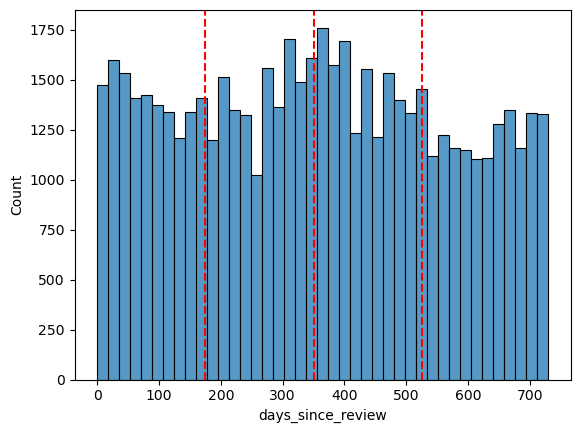

In [83]:
plt.figure()
sns.histplot(hr_samp['days_since_review'])
plt.axvline(175, color='red',linestyle='--')
plt.axvline(350, color='red',linestyle='--')
plt.axvline(525, color='red',linestyle='--')
plt.show()

### Encoding `Total_Number_of_Reviews_Reviewer_Has_Given`

As mentioned in the preprocessing, encoding this variable may be a good indicator of whether a reviewer is a frequent reviewer (and therefore may have a skew in their rating). It was decided to use reviewers of 3 or more hotels are a 'frequent' reviewer. Therefore, a single dummy variable for a review frequency will be created.

## Non-Numeric Columns <a id=cats a>

As seen in our exploratory data analysis, the columns we will consider changing from non-numeric to numeric are: 
- `Hotel_Address`
- `Reviewer Nationality` 
- `Tags`
- A Countries Variable
- `Negative_Review`
- `Positive_Review`


We will vectorise `Negative_Review` and `Positive_Review` in order to get an understanding of the sentiment involved in these reviews. However, we will do this after splitting our data into training and testing sets because this will ensure that we do not have any issues of creating vectors of different sizes and overfitting to our data. Other than this `Hotel_Address`, `Reviewer Nationality` and `Tags` are all encodable because they are ordinal values. We will start with `Hotel_Address`.

### `Hotel_Address`

Though the `Hotel_Address` feature may be useful in its specificity, as a hotel may just be better or worse overall, there is an issue of relevance in the dataset. The EDA exposed that there are many hotels in the dataset, which could lead to individual hotel encodings appearing too infrequently to be considered viable features. We will check this assumption below. 

In [84]:
# Creating dense 
hotel_encode = ds_utils.ohe_dense(hr_samp['Hotel_Address'])
print(hotel_encode.shape)

(56314, 1468)


As a binary variables, the means can be used to find the frequency within the dataset. 

In [85]:
hotel_apps = hotel_encode.mean().sort_values(ascending=False).to_frame().rename(columns={0:'percent_appeared'})

In [86]:
hotel_apps.describe()

,percent_appeared
count,1468.000000
mean,0.000681
std,0.000873
min,0.000018
25%,0.000178
50%,0.000373
75%,0.000870
max,0.009820


From this we can see that the most common hotel only appears in the dataset 0.9% of the data. This makes sense as there are a wide range of hotels. Thinking more about this variable, it seems that it would add little value to the dataset (because all dummies appear less than 5% of the time). `Hotel_Address` would have been used as a unique encode for the hotel, but the dataset is so wide that specific hotel data is not relevant. For this reason, we will continue on without a unique hotel identifier, and can consider that `lat` or `lon` could bring us some value in a similar way.

However, it will be used to create the country variable (as discussed in the EDA) which will be in turn encoded. 

### `Reviewer_Nationality`

As mentioned, we will create dummy variables for UK and USA reviewers, as these are the only countries from which reviewers appear more than 5% of the time. Because we are not using all possible reviewer countries, our inherent reviewer is from neither the USA or the UK, this means we will have no issues of multicollinearity. 

### Encoding `Tags` 

Now we will look at encoding our tags variable. From our inspection we saw that these are in the form of strings, though they look like lists, so they need to be altered.

We will create lists from these strings by removing the brackets at the start and end, along with the `"` character. Then we will split based on the ` ', ' ` values between each tag. As some tags are multiple words, this splitting will give us the tags separate.  

We will use the `CountVectorizer()` function to create a matrix of which rows contain which tags. Though `CountVectorizer()` is commonly used in conjuction with language processing, we are not actually concerned with the linguistic value of each tag. Instead we can think of seeing if rows in similar groups have patterns in their `good_review` distinction. For this reason we will put some limitations on the processing done. As we do not want to tokenize we will pass in a lambda function that makes no alterations to the data. We will also need to define `lowercase=False` to ensure we don't face any issues. This means that we will get only the values of the list as tokens, as we want because we do not want to break these down further (as we are treating all tags themselves as categories).

At this point we have a huge amount of data for our tags. Taking all of this data to our model will create computational load issues and may overcomplicate a model. Looking more deeply found that a majority of the tags appear less than 0.01% of the time. Good practice is to remove variables that are missing 95% of the time or more. By removing variables that appear less than 5% of the time, we finish we 14 tags. It seems reasonable that we can consider the statistical significance more deeply, however, because these are not all dependant on one another, we do not need to worry about issues of 

### `Country` Variable

As mentioned, a variable for the country of each hotel will be created, and then encoded. This will create six variables, so one will need to be removed to combat multicollinearity. 

### `Positive_Review` and `Negative_Review` Missing Values

Though we will vectorize the mentioned variables separately, there is one change that needs to be made to the reviews, removing the 'No Negative' and 'No Positive' distinctions. These are essentially markers of missing data. It is important that these missing data distinctions are removed, so that the words within them are not actually used in the language processing. (For example, the word 'Negative' appearing in the `Negative_Review` column could be an indication of a strongly bad experience).

In [87]:
hr_samp['Negative_Review'].replace('No Negative', '', inplace=True)
hr_samp['Positive_Review'].replace('No Positive', '', inplace=True)

## Executing Variable Alterations <a id=alts a>

The following function call to `hotel_encoding` from within the `hotel_nlp` package will perform all of the above mentioned preprocessing. The only remaining variables to consider are the `Positive_Review` and `Negative_Review` variables. Vectorizing these variables will be done more explicitly, as their contents need further inspection than the other variables and if we do this process before splitting into training and testing sets we will create a bias towards our specific sample of the data.
    
As discussed there are some non-numeric variables that will need to be removed from our dataframe in order to let us go on with our modelling. Namely, `Review_Date`, `Hotel_Name`. We will also drop `Reviewer_Score` because we have created `good_review` to be used as our dependent variable.

We will also remove `Hotel_Address`, as we have found no value in it, `Reviewer_Nationality` because we have added in columns with value from encoding this variable, `Tags` and `Tags_list` because we have encoded this.

In [88]:
hr_samp_encoded = hotel_nlp.hotel_encoding(hr_samp)

In [89]:
hr_samp_encoded[hr_samp_encoded.duplicated()]

,Additional_Number_of_Scoring,Average_Score,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,lat,lng,good_review,...,Austria,France,Italy,Kingdom,Netherlands,Spain,0-175,175-350,350-525,525+
49753,1258,9.4,Nothing,2,4204,Everything,2,51.502435,-0.00025,1,...,0,0,0,1,0,0,1,0,0,0


After performing the preprocessing we end up with the following columns, as non-useful ones have been removed. As a note, no variables have been removed from the encoding, meaning that the current list of columns would be prone to multicollinearity. We will consider which dummy variables to remove, based on their statistical significance later. 

Now we can see that our final set of attributes, before we consider vectorising, are:

In [90]:
hr_samp_encoded.columns

Index(['Additional_Number_of_Scoring', 'Average_Score', 'Negative_Review',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Positive_Review', 'Review_Total_Positive_Word_Counts', 'lat', 'lng',
       'good_review', 'frequent_reviewer', 'uk_reviewer', 'usa_reviewer',
       'Leisure_trip', 'Submitted_from_a_mobile_device', 'Couple',
       'Stayed_1_night', 'Stayed_2_nights', 'Solo_traveler', 'Stayed_3_nights',
       'Business_trip', 'Group', 'Family_with_young_children',
       'Stayed_4_nights', 'Double_Room', 'Standard_Double_Room',
       'Superior_Double_Room', 'Austria', 'France', 'Italy', 'Kingdom',
       'Netherlands', 'Spain', '0-175', '175-350', '350-525', '525+'],
      dtype='object')

# Splitting Into Training and Testing <a id=Splitting a>

In order to test the strength of our model, we will need to split our sample into a training set and a testing set. At this point, we cannot perfrom any validation because we are not creating predictions. Instead we will make this split in order to understand the strength of our `Positive_Review` and `Negative_Review` vectorizations. 
    
Once we have downsampled, we are going to resample our data so that we have an equal representation of the two classes in the `good_review` variable. Having an equal split will make sure our modelling is not skewed by a skew in the data. Because we are going to downsample our training set, we will take a smaller percentage of testing data at this point, so that when we do the down sampling, and lose some data points, we will end up with a larger proportion of testing than our distinction. 

From our earlier exploration we saw that about 43% of our total data has a `0` distinction for `good_review`. Meaning we will need to lose about 25% of our training data to get a balance (43/57 $\approx$ 25). 

Downsampling involves removing some of our over represented class so that we will have an equal number of data points for both classes. We will use the `resample()` function in order to do this, it takes in X and y data and creates a sample of these based on the number of samples distinction. In order to get the correct size we will pass in the size of the training set with a `good_review` disctinction of `0`. We will then add this new sample of positive `good_review` values to a dataset of only the negative `good_review` data points. This will give us a training set with equal parts.

In [91]:
X_train_bal, y_train_bal, X_test, y_test = hotel_nlp.train_test_downsample(hr_samp_encoded)

Before Downsampling:
Number of negative 'good_review' values in training set: 18837
Number of positive 'good_review' values in training set: 25087

After Downsampling:
Number of negative 'good_review' values in training set: 18837
Number of positive 'good_review' values in training set: 18837

Test Size: 12390
Train Size: 37674
Total Sample Size: 50064 (proportionally: 0.11)
New Train/Test Split Proportion: 0.247


Our sample size is about 11%, but we have a resampled training set and a test size of about 25%. At this point we are happy with our training and testing sets and can begin looking at modelling. 

# Vectorizing Positive and Negative Reviews <a id=Vect a>

Now that we have most of our data in a numeric form, we can begin to think about how we will use the actual positive and negative reviews to see how likely a review is to be categorisable as good. We are going to start with the good news! Positive Reviews!

## `Positive_Review` <a id=pos a>

We are going to create a dataframe in which we will keep all of the iterations of our positive review vectorisations. This will help us to consider which vectorisation to use after trying a few.   

For this section of our exploration we will be using only the `Positive_Review` column, so we will make a temporary X variable for this exploration.

In [92]:
pos_vecs = pd.DataFrame(columns=['model','parameters','train_score','test_score','vectoriser','number of features'])
pos_train = X_train_bal['Positive_Review']
pos_test = X_test['Positive_Review']

### Starting with a Bag of Words Model

We will start with a simple model that has all of the tokens seen, and tokens just being words that appear in the documents. Then we will introduce removing stop words and finally we will apply a tokenizer that applies stemming to handle stop words. These three Bag of Words count vectorisations will be tested, and compared, using a LogisticRegression. Through out following analysis we will keep our model the same, this will allow us to consider how altering features will impact our success in predicting `good_review`. It could be considered which model performs best and then see how feature engineering affects that - but feature engineering itself could change which model would be best suited. A LogisticRegression was chosen because it is the simplest model that has a fairly quick fitting time. This is helpful for us in this case because we are going to be running similar models, with tweaked parameters. As we only have a two class classification, we are not concerned with the computational load that would come with adding multiple classes, and having to run multiple regressions to classify our data. 

Looking at our base, stop-word removed and tokenised vectorisations first will give us a good jumping off point. We do this by calling the `base_stop_stem` function from the `ds_utils` library. This function fits a vectoriser three times, as the default is CountVectorizer, implemented in the `bagofwords` function, we do not need to pass this value in. `base_stop_stem` runs a basic CountVectorizer, with no stop words processing and the default tokenisation. It then runs the Vectorizer but while ignoring stop words. Finally, it performs some stemming while considering stop words. In order to perform stemming on the two vectorisers we will be using, CountVectorizer and TfidfVectorizer, we will use a custom tokeniser that applies stemming to all words seen, except common stop words (as defined in the chosen [nltk](#https://www.nltk.org/) library). The function for this stemming is called `rev_tokenizer`, within the `ds_utils` library. 

In [19]:
# run intial vectorisers (base, no stop words and with stemming)
pos_vecs = hotel_nlp.base_stop_stem(pos_train, pos_test, y_train_bal, y_test, pos_vecs)

                                      model parameters  train_score  \
0  LogisticRegression(C=0.1, max_iter=2000)      c=0.1     0.741954   

   test_score                               vectoriser number of features  
0    0.689669  <function bagofwords at 0x7f9c746c5430>              11948  


/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [20]:
pos_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.741954,0.689669,<function bagofwords at 0x7f9c746c5430>,11948
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.725493,0.675868,<function bagofwords at 0x7f9c746c5430>,11666
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.729324,0.686199,<function bagofwords at 0x7f9c746c5430>,8975


Our base model does pretty well! Though removing stop words reduced our dimensionality it reduced both our test_score and train_scores. This may be the result of overfitting in the case of using all of the features. Looking at the model but with stemming in the tokenisation shows that our model has lost very little accuracy (compared to the base) but has significantly dropped features (nearly 30%). From this we can easily conclude that we do not need the features that we lost from stemming.

However, we still have a very large number of features. It will now be helpful to look at how limiting the frequencies of documents affects our model, while reducing the dimensions. We will start by limiting the minimum frequency of tokens in the document (`min_df`). Passing an x value into this parameter allows us to limit the features to only tokens that appear at least x times. This means that we remove features that appear infrequntly (this depends on how we define infrequnetly) so that we reduce dimensionality and remove unnecessary features. 

As we do this we will look at the distribution of our feature appearances so that we can better understand the range in frequencies - we will use the de-stemmed and de-stop-worded model we just ran.

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

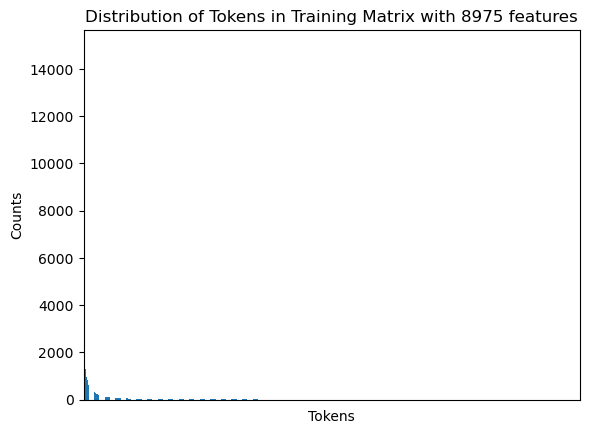

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

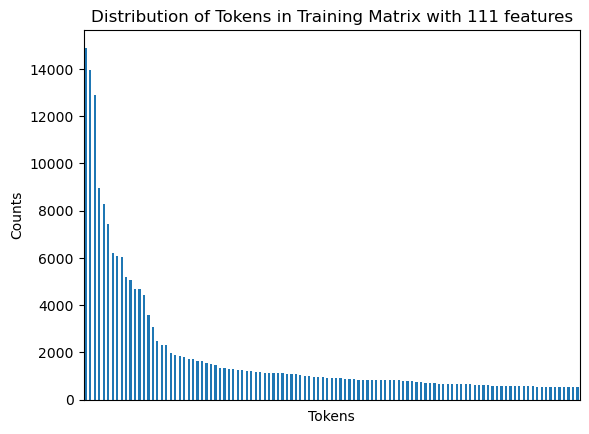

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

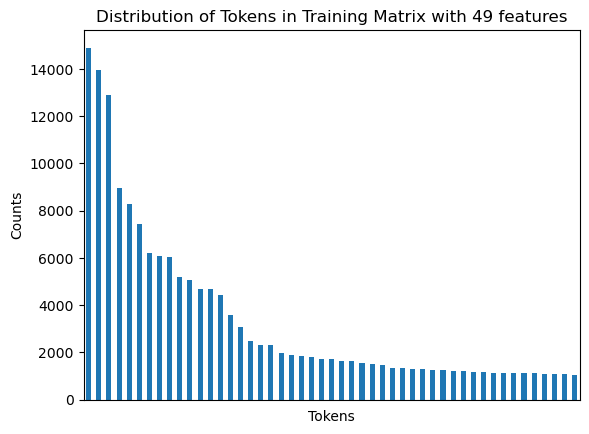

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

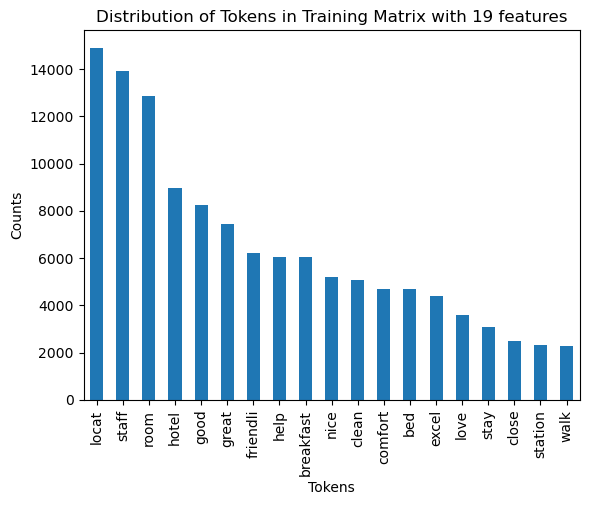

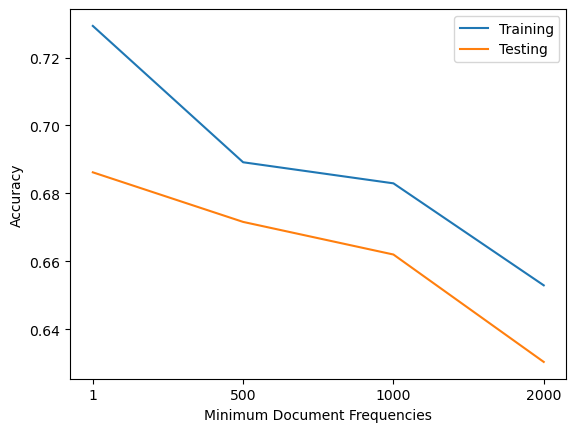

In [21]:
pos_vecs = hotel_nlp.vectoriser_min_max_explore(pos_train, pos_test, y_train_bal, y_test, pos_vecs, 
                                               min_df__=[1,500,1000,2000])

In [22]:
pos_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.741954,0.689669,<function bagofwords at 0x7f9c746c5430>,11948
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.725493,0.675868,<function bagofwords at 0x7f9c746c5430>,11666
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.729324,0.686199,<function bagofwords at 0x7f9c746c5430>,8975
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.729324,0.686199,<function bagofwords at 0x7f9c746c5430>,8975
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.689161,0.671590,<function bagofwords at 0x7f9c746c5430>,111
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.682952,0.661985,<function bagofwords at 0x7f9c746c5430>,49
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.652909,0.630347,<function bagofwords at 0x7f9c746c5430>,19


In [23]:
pos_bag_model, pos_bag_train, pos_bag_test = ds_utils.bagofwords(pos_train, pos_test, min_df_=2000, tokenizer_=ds_utils.rev_tokenizer)
pos_bag_feats = pos_bag_model.get_feature_names_out()

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


From this output we can see that limiting our `min_df` to only above 2000 has a small impact on the accuracy, while reducing the number of features significantly. If we chose to limit to 2000, our training accuracy will decrease, from the base model, by 10% with an almost 4% decrease in test accuracy. The training accuracy reduction could be argued as a result of removing overfitting. 

The last and second to last graph shows that raising the `min_df` from 1000 to 2000 removes the tail of features with little impact. At this point we have a reasonable reduction in features, while having not reducing our accuracy too much. It will now be interesting to see if a TD-IDF CountVectorisation would do the same thing, but with better accuracy. Again, we will only use Logistic Regression so that we can be sure that we are comparing our models fairly.

## TD-IDF 

We will now start using a Count Vectoriser that employs TD-IDF to scale the term frequency we have been looking at so far by the inverse of the amount of times that specific term appears in the whole corpus. In other words, terms that appear less frequently in the whole corpus will be given more weight. We will use the same thought process as with bag of words, in that we will create a base model, one with stop words considered and one that uses our tokenization function. We will add these to our running data frame of `Positive_Review` feature engineered models (this way we can compare the td_idf models with the bag of words models).

In [24]:
# adding our base, stop words and stemming simple models but this time using td_idf 
pos_vecs = hotel_nlp.base_stop_stem(pos_train, pos_test, y_train_bal, y_test, pos_vecs, vector=ds_utils.my_tdidf)

                                      model                parameters  \
0  LogisticRegression(C=0.1, max_iter=2000)                     c=0.1   
0  LogisticRegression(C=0.1, max_iter=2000)  c=0.1, stopwords=english   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)                     c=0.1   

   train_score  test_score                               vectoriser  \
0     0.741954    0.689669  <function bagofwords at 0x7f9c746c5430>   
0     0.725493    0.675868  <function bagofwords at 0x7f9c746c5430>   
0     0.729324    0.686199  <function bagofwords at 0x7f9c746c5430>   
0     0.729324    0.686199  <function bagofwords at 0x7f9c

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [25]:
pos_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.741954,0.689669,<function bagofwords at 0x7f9c746c5430>,11948
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.725493,0.675868,<function bagofwords at 0x7f9c746c5430>,11666
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.729324,0.686199,<function bagofwords at 0x7f9c746c5430>,8975
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.729324,0.686199,<function bagofwords at 0x7f9c746c5430>,8975
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.689161,0.671590,<function bagofwords at 0x7f9c746c5430>,111
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.682952,0.661985,<function bagofwords at 0x7f9c746c5430>,49
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.652909,0.630347,<function bagofwords at 0x7f9c746c5430>,19
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.717936,0.694270,<function my_tdidf at 0x7f9c746c54c0>,11948
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.705015,0.676594,<function my_tdidf at 0x7f9c746c54c0>,11666
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.710273,0.689588,<function my_tdidf at 0x7f9c746c54c0>,8975


From this output it is clear that the TD-IDF vectorisation performs worse than the Bag of Words method. We still, however, have a very large number of features so we will use the same method as above, altering `min_df`, in order to limit our features. 

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

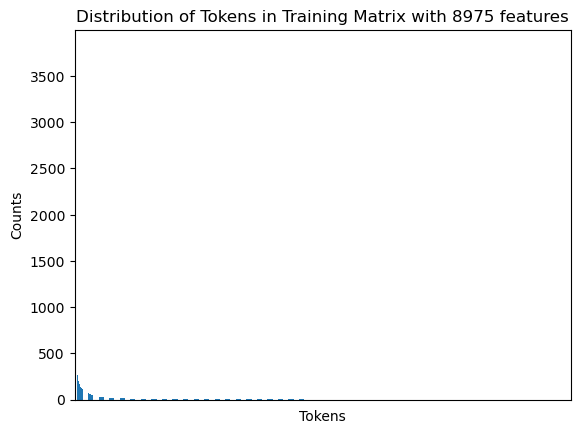

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

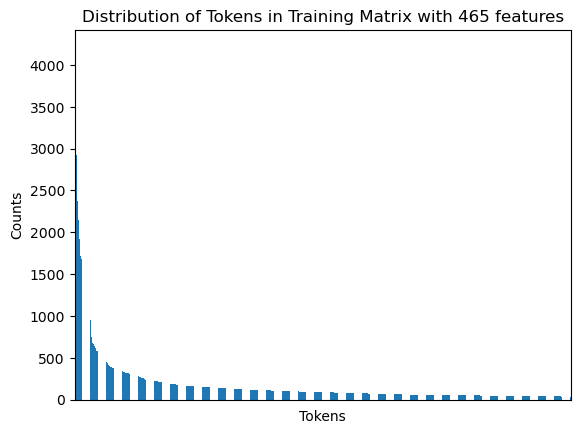

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

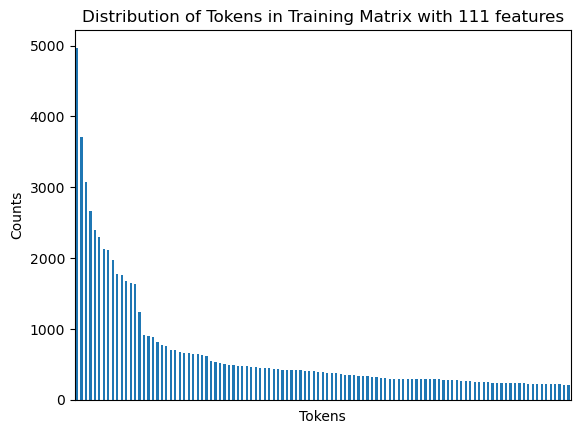

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

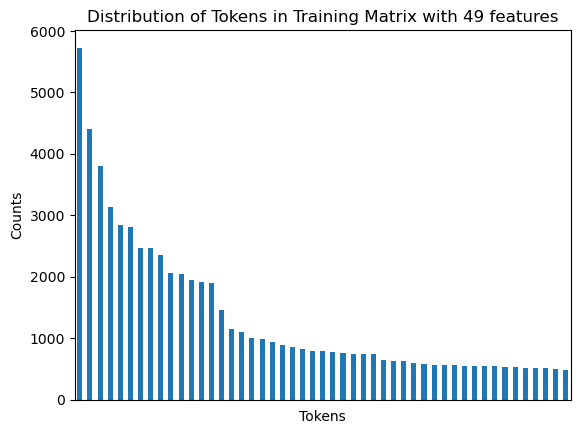

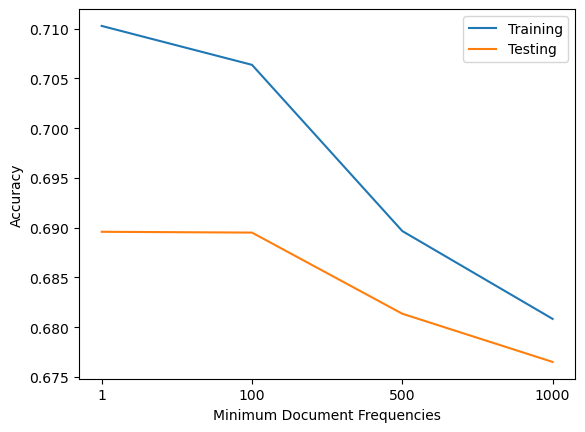

In [26]:
pos_vecs = hotel_nlp.vectoriser_min_max_explore(pos_train, pos_test, y_train_bal, y_test, pos_vecs,
                                               vector=ds_utils.my_tdidf, min_df__=[1,100,500,1000])

In [27]:
pos_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.741954,0.689669,<function bagofwords at 0x7f9c746c5430>,11948
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.725493,0.675868,<function bagofwords at 0x7f9c746c5430>,11666
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.729324,0.686199,<function bagofwords at 0x7f9c746c5430>,8975
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.729324,0.686199,<function bagofwords at 0x7f9c746c5430>,8975
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.689161,0.671590,<function bagofwords at 0x7f9c746c5430>,111
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.682952,0.661985,<function bagofwords at 0x7f9c746c5430>,49
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.652909,0.630347,<function bagofwords at 0x7f9c746c5430>,19
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.717936,0.694270,<function my_tdidf at 0x7f9c746c54c0>,11948
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.705015,0.676594,<function my_tdidf at 0x7f9c746c54c0>,11666
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.710273,0.689588,<function my_tdidf at 0x7f9c746c54c0>,8975


Similarly to the Bag of Words vectorisation we see a reduction in training accuracy, however the reduction is not as drastic. We still have large tails on our token distributions, so it is a good idea to restrict the `min_df` further. From the last graph it seems that a count of around 1750 will remove the tail without over reducing the dimensions. However, in our modelling we will also look at the statistical significance and coefficients to determine the most relevant attributes. Because of this we will not reduce our dimensions to minimum appearances of 1750, but instead take all attributes that appear in more than 100 documents (min_df = 100). However, it is interesting the compare the tdidf output to the bag of words output.

In [28]:
pos_tdidf_model_1750, pos_tdidf_train_1750, pos_tdidf_test_1750 = ds_utils.my_tdidf(pos_train, pos_test, min_df_=1750, tokenizer_=ds_utils.rev_tokenizer)
pos_tdidf_feats_1750 = pos_tdidf_model_1750.get_feature_names_out()

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


We again see a reduction, but not by much given that we have almost doubled our `min_df`.

Lets compare the result of our td_idf and bagofwords chosen features:

In [29]:
print(pos_bag_feats)

['bed' 'breakfast' 'clean' 'close' 'comfort' 'excel' 'friendli' 'good'
 'great' 'help' 'hotel' 'locat' 'love' 'nice' 'room' 'staff' 'station'
 'stay' 'walk']


In [30]:
print(pos_tdidf_feats_1750)

['bed' 'breakfast' 'clean' 'close' 'comfort' 'everyth' 'excel' 'friendli'
 'good' 'great' 'help' 'hotel' 'locat' 'love' 'nice' 'restaur' 'room'
 'servic' 'staff' 'station' 'stay' 'walk']


Interestingly, we ended up with very similar attributes. The TD-IDF did slightly better than the Bag of Words, so we will use the matrix from this vectorisation and doing this will give a few more attributes to consider in our modelling (especially when we begin to consider the statistical significance of the relationships). 

We will create the matrices for the train set and the test set below (the train set was used to fit and we transformed the test based on this), with the minimum appearance of 100. 

In [94]:
pos_tdidf_model, pos_tdidf_train, pos_tdidf_test = ds_utils.my_tdidf(pos_train, pos_test, min_df_=100, tokenizer_=ds_utils.rev_tokenizer)
pos_tdidf_feats = pos_tdidf_model.get_feature_names_out()

pos_rev_train_feats = pd.DataFrame(columns=pos_tdidf_feats, data=pos_tdidf_train.toarray())
pos_rev_test_feats = pd.DataFrame(columns=pos_tdidf_feats, data=pos_tdidf_test.toarray())

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## `Negative_Review` <a id=neg a>

Now we will start to look at the `Negative_Review`, again we will create temporary X vectors in order to allow us to easily work with our data.

In [96]:
neg_train = X_train_bal['Negative_Review']
neg_test = X_test['Negative_Review']

In [97]:
# Creating dataframe for our negative reviews 
neg_vecs = pd.DataFrame(columns=['model','parameters','train_score','test_score','vectoriser','number of features'])

### Bag of Words with `Negative_Review`

We will start the exact same way as we did with `Positive_Review`, by fitting all features, then removing stop words and then applying our tokenizer on a Bag of Words Vectoriser. The code is below and will be reported in the neg_vecs dataframe.

In [35]:
neg_vecs = hotel_nlp.base_stop_stem(neg_train, neg_test, y_train_bal, y_test, neg_vecs)

                                      model parameters  train_score  \
0  LogisticRegression(C=0.1, max_iter=2000)      c=0.1     0.768271   

   test_score                               vectoriser number of features  
0    0.740355  <function bagofwords at 0x7f9c746c5430>              15512  


/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
neg_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.768271,0.740355,<function bagofwords at 0x7f9c746c5430>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.759208,0.733414,<function bagofwords at 0x7f9c746c5430>,15216
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868


In the case of our `Negative_Review`, adding our custom tokeniser does not have a large impact on training or testing, but seriously reduces dimensionality (by 50%!). This is good news, and we hope to see that further reducing the dimensions using `min_df` will have little reduction in accuracy. 

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

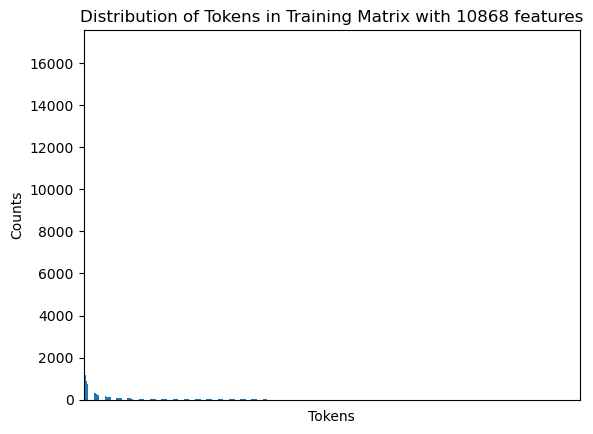

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

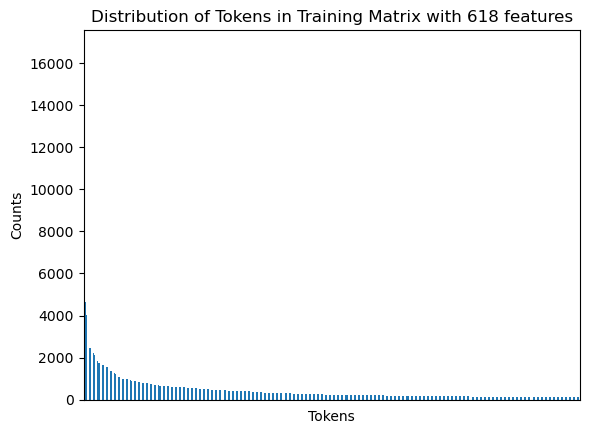

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

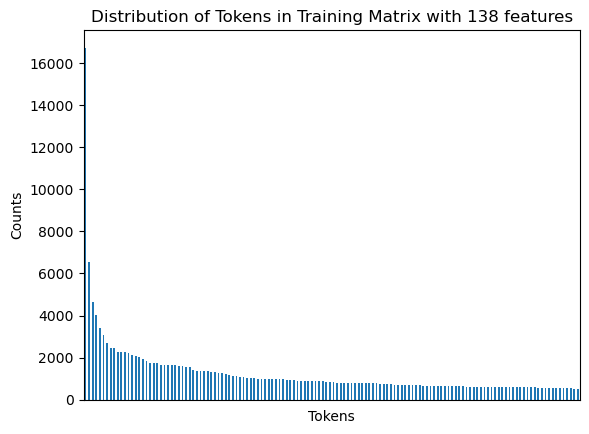

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

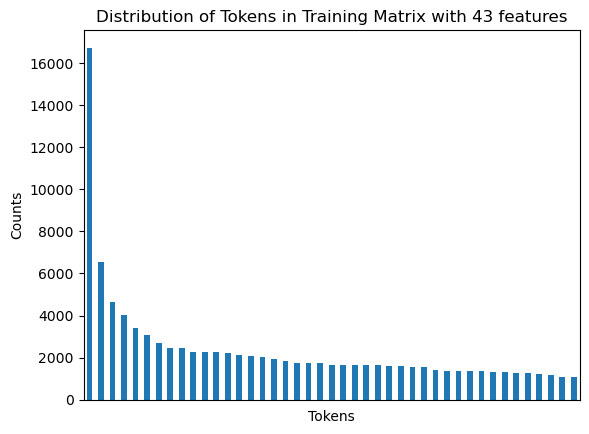

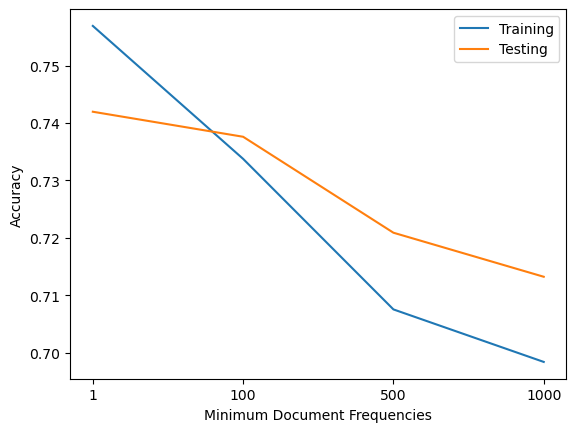

In [37]:
neg_vecs = hotel_nlp.vectoriser_min_max_explore(neg_train, neg_test, y_train_bal, y_test, neg_vecs, 
                                               min_df__=[1,100,500,1000])

In [38]:
neg_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.768271,0.740355,<function bagofwords at 0x7f9c746c5430>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.759208,0.733414,<function bagofwords at 0x7f9c746c5430>,15216
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.733763,0.737611,<function bagofwords at 0x7f9c746c5430>,618
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.707552,0.720904,<function bagofwords at 0x7f9c746c5430>,138
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.698409,0.713236,<function bagofwords at 0x7f9c746c5430>,43


From the bottom distribution we can see that there is still a large tail, we will look at the result if we limit our `min_df` to 1500.

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

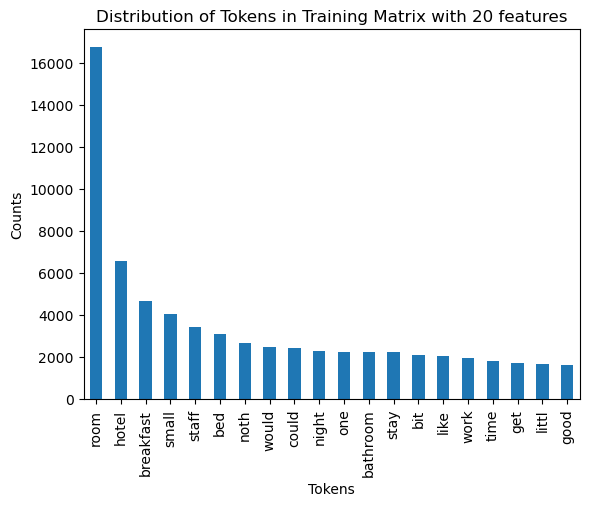

Train Score: 0.6906410188659303
Test Score: 0.7064568200161421


In [39]:
neg_vecs = hotel_nlp.vectoriser_min_max_explore(neg_train, neg_test, y_train_bal, y_test, neg_vecs, min_df__=[1500])

In [40]:
neg_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.768271,0.740355,<function bagofwords at 0x7f9c746c5430>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.759208,0.733414,<function bagofwords at 0x7f9c746c5430>,15216
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.733763,0.737611,<function bagofwords at 0x7f9c746c5430>,618
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.707552,0.720904,<function bagofwords at 0x7f9c746c5430>,138
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.698409,0.713236,<function bagofwords at 0x7f9c746c5430>,43
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.690641,0.706457,<function bagofwords at 0x7f9c746c5430>,20


From this output we can see that limiting our `min_df` to only above 1500 leads to a 8% reduction in training accuracy and 4% reduction in test accuracy, while reducing the number of features significantly. Again, the training accuracy reduction could be argued as a result of removing overfitting. From the last and second to last graphs we can see that we have significantly removed the tail of our distribution, meaning we have gotten rid of a lot of unnecessary features.

It will now be interesting to see if a TD-IDF CountVectorisation would do the same thing, but with better accuracy. Again, we will only use Logistic Regression so that we can be sure that we are comparing our models fairly.

In [41]:
neg_bag_model, neg_bag_train, neg_bag_test = ds_utils.bagofwords(neg_train, neg_test, min_df_=1500, tokenizer_=ds_utils.rev_tokenizer)
neg_bag_feats = neg_bag_model.get_feature_names_out()

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [42]:
print(neg_bag_feats)

['bathroom' 'bed' 'bit' 'breakfast' 'could' 'get' 'good' 'hotel' 'like'
 'littl' 'night' 'noth' 'one' 'room' 'small' 'staff' 'stay' 'time' 'work'
 'would']


### TD_IDF with `Negative_Review`

We will now look to see if using a TD-IDF vectoriser will give us a more or less accurate model. 

In [43]:
neg_vecs = hotel_nlp.base_stop_stem(neg_train, neg_test, y_train_bal, y_test, neg_vecs, vector=ds_utils.my_tdidf)

                                      model                parameters  \
0  LogisticRegression(C=0.1, max_iter=2000)                     c=0.1   
0  LogisticRegression(C=0.1, max_iter=2000)  c=0.1, stopwords=english   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)       c=0.1, nltk stemmer   
0  LogisticRegression(C=0.1, max_iter=2000)                     c=0.1   

   train_score  test_score                               vectoriser  \
0     0.768271    0.740355  <function bagofwords at 0x7f9c746c5430>   
0     0.759208    0.733414  <function bagofwords at 0x7f9c746c5430>   
0     0.756910    0.741969  <function bagofwords at 0x7f

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
neg_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.768271,0.740355,<function bagofwords at 0x7f9c746c5430>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.759208,0.733414,<function bagofwords at 0x7f9c746c5430>,15216
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.733763,0.737611,<function bagofwords at 0x7f9c746c5430>,618
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.707552,0.720904,<function bagofwords at 0x7f9c746c5430>,138
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.698409,0.713236,<function bagofwords at 0x7f9c746c5430>,43
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.690641,0.706457,<function bagofwords at 0x7f9c746c5430>,20
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.742773,0.729136,<function my_tdidf at 0x7f9c746c54c0>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.742641,0.726069,<function my_tdidf at 0x7f9c746c54c0>,15216


As with `Positive_Review` the TD-IDF does less well than the Bag of Words, but the reduction in accuracy when limiting the possible token values is tiny. Again, the dimension reduction was about 50% but we still have more than 10,000 features so we will begin raising our `min_df`.

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

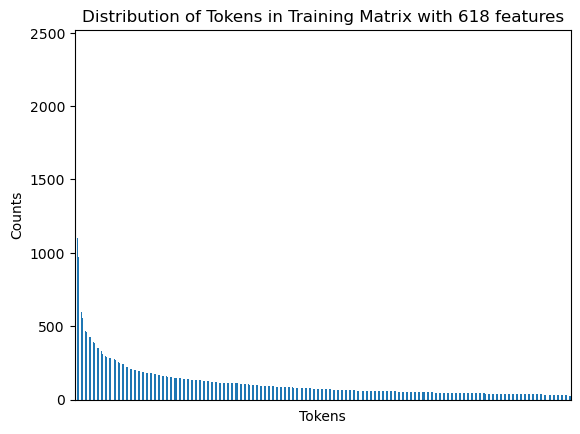

Train Score: 0.7380964963272209
Test Score: 0.7307506053268765


In [45]:
neg_vecs = hotel_nlp.vectoriser_min_max_explore(neg_train, neg_test, y_train_bal, y_test, neg_vecs, 
                                               vector=ds_utils.my_tdidf, min_df__=[100])

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

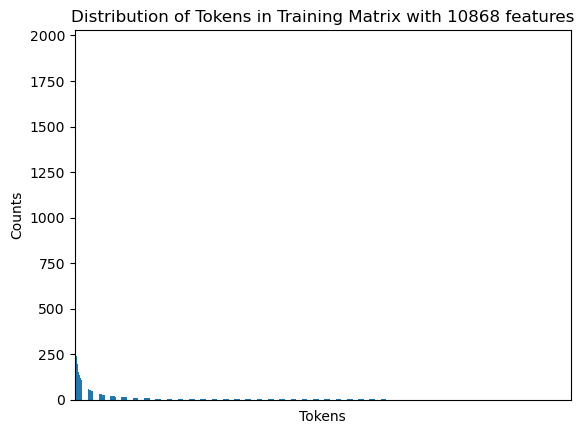

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

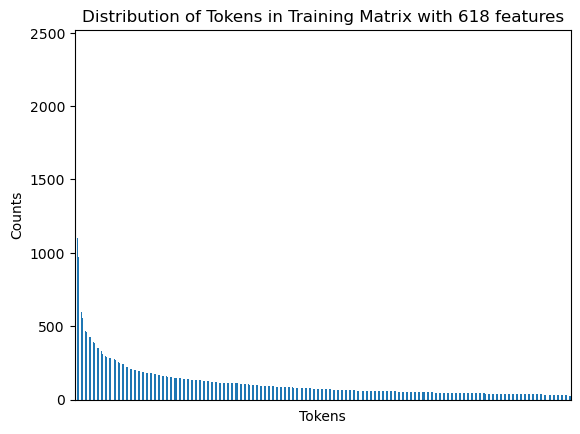

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

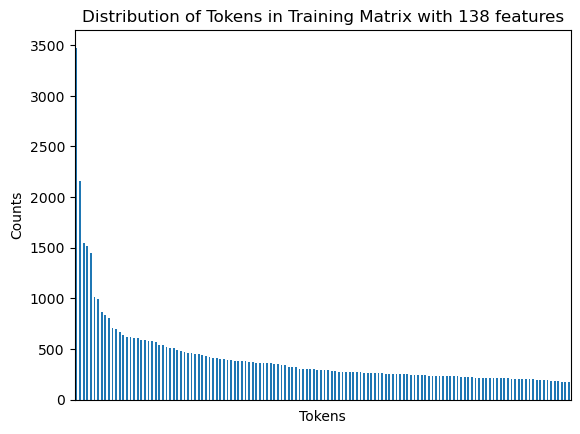

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

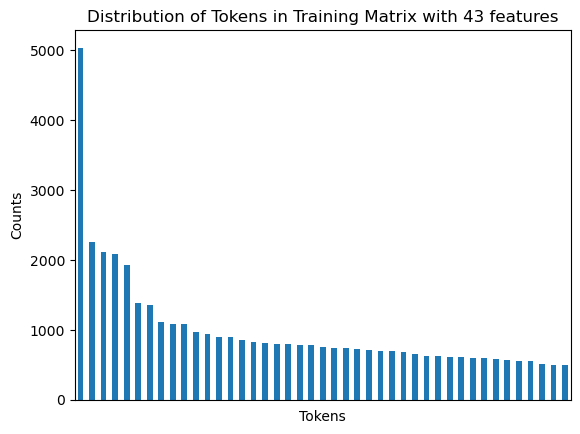

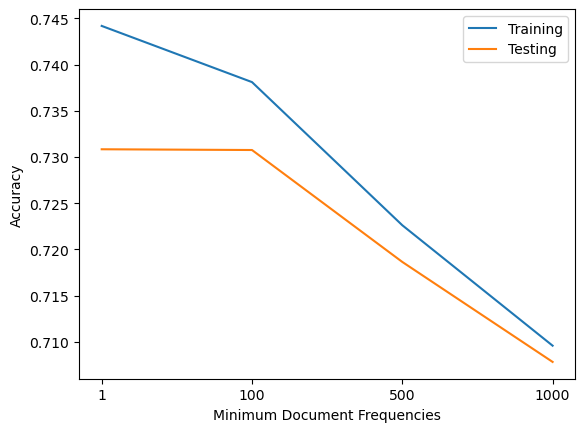

In [46]:
neg_vecs = hotel_nlp.vectoriser_min_max_explore(neg_train, neg_test, y_train_bal, y_test, neg_vecs, 
                                               vector=ds_utils.my_tdidf, min_df__=[1, 100, 500, 1000])

In [47]:
neg_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.768271,0.740355,<function bagofwords at 0x7f9c746c5430>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.759208,0.733414,<function bagofwords at 0x7f9c746c5430>,15216
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.733763,0.737611,<function bagofwords at 0x7f9c746c5430>,618
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.707552,0.720904,<function bagofwords at 0x7f9c746c5430>,138
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.698409,0.713236,<function bagofwords at 0x7f9c746c5430>,43
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.690641,0.706457,<function bagofwords at 0x7f9c746c5430>,20
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.742773,0.729136,<function my_tdidf at 0x7f9c746c54c0>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.742641,0.726069,<function my_tdidf at 0x7f9c746c54c0>,15216


The output above shows us that there are decreases in accuracy, but like we have seen these decreases are small enough to justify removing the features. In the TD-IDF case, limiting to 1000 min_df only reduces the accuracy compared to the stem-tokeniser by 3%.

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Figure size 640x480 with 0 Axes>

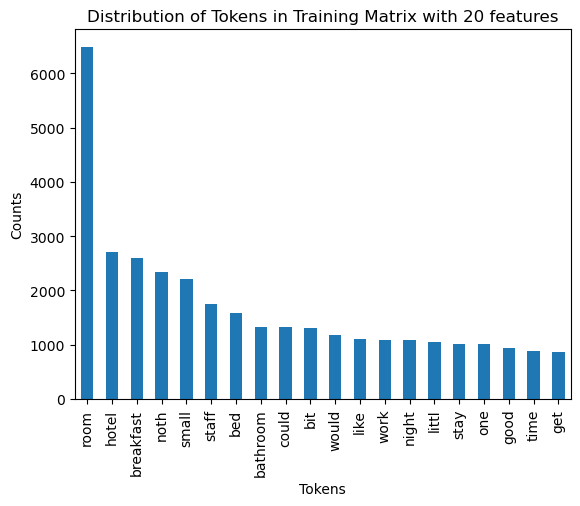

Train Score: 0.6983829202557734
Test Score: 0.7014527845036319


In [48]:
neg_vecs = hotel_nlp.vectoriser_min_max_explore(neg_train, neg_test, y_train_bal, y_test, neg_vecs,
                                               vector=ds_utils.my_tdidf, min_df__=[1500])

In [49]:
neg_vecs

,model,parameters,train_score,test_score,vectoriser,number of features
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.768271,0.740355,<function bagofwords at 0x7f9c746c5430>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.759208,0.733414,<function bagofwords at 0x7f9c746c5430>,15216
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.756910,0.741969,<function bagofwords at 0x7f9c746c5430>,10868
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.733763,0.737611,<function bagofwords at 0x7f9c746c5430>,618
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.707552,0.720904,<function bagofwords at 0x7f9c746c5430>,138
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.698409,0.713236,<function bagofwords at 0x7f9c746c5430>,43
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, nltk stemmer",0.690641,0.706457,<function bagofwords at 0x7f9c746c5430>,20
0,"LogisticRegression(C=0.1, max_iter=2000)",c=0.1,0.742773,0.729136,<function my_tdidf at 0x7f9c746c54c0>,15512
0,"LogisticRegression(C=0.1, max_iter=2000)","c=0.1, stopwords=english",0.742641,0.726069,<function my_tdidf at 0x7f9c746c54c0>,15216


From this output it seems that limiting the `min_df` to 1500 would be good, as this will give us features while removing the majority of the tail. However, in our modelling we will consider statistical significance as well PCA as another form of dimensionality reduction. For this reeason we will use the min_df = 1500 to, again, compare to the bag of words model but will take all attributes with a minimum document frequency above 100. 

In [50]:
neg_tdidf_model_1500, neg_tdidf_train_1500, neg_tdidf_test_1500 = ds_utils.my_tdidf(neg_train, neg_test, min_df_=1500, 
                                                                     tokenizer_=ds_utils.rev_tokenizer)
neg_tdidf_feats_1500 = neg_tdidf_model_1500.get_feature_names_out()

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


We will now compare the features selected by the bagofwords vectoriser and the TD-IDF vectoriser

In [51]:
print(neg_bag_feats)
print(neg_tdidf_feats_1500)

['bathroom' 'bed' 'bit' 'breakfast' 'could' 'get' 'good' 'hotel' 'like'
 'littl' 'night' 'noth' 'one' 'room' 'small' 'staff' 'stay' 'time' 'work'
 'would']
['bathroom' 'bed' 'bit' 'breakfast' 'could' 'get' 'good' 'hotel' 'like'
 'littl' 'night' 'noth' 'one' 'room' 'small' 'staff' 'stay' 'time' 'work'
 'would']


This time we got identical outputs, and very similar accuracy results. As the vectorisers produced matrices with the same features, and the feature counts are inherent to the data the two matrices will be identical. At this point it does not matter which matrix we use, but we will use the TD-IDF version (because we went through the effort of making it!). The code to create the training and testing dataframes for negative reviews is below.

In [98]:
neg_tdidf_model, neg_tdidf_train, neg_tdidf_test = ds_utils.my_tdidf(neg_train, neg_test, min_df_=100, 
                                                                     tokenizer_=ds_utils.rev_tokenizer)
neg_tdidf_feats = neg_tdidf_model.get_feature_names_out()

neg_rev_train_feats = pd.DataFrame(columns=neg_tdidf_feats, data=neg_tdidf_train.toarray())
neg_rev_test_feats = pd.DataFrame(columns=neg_tdidf_feats, data=neg_tdidf_test.toarray())

/Users/pippidebree/opt/anaconda3/envs/capenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Combining Matrices <a id=combo a>

Now we want to add these matrices of features back to our training data. However, we noticed that there may be some overlap between the positive review features and negative review features. Keeping the words for both of these is essential as they may have different meanings in the positive or negative context. In order to track whether the features came from the positive and negative reviews, a `p_` or `n_` prefix will be added to the beginning. This way words appearing in both can be differentiated. 

In [101]:
pos_rev_test_feats = pos_rev_test_feats.add_prefix('p_')
pos_rev_train_feats = pos_rev_train_feats.add_prefix('p_')

neg_rev_test_feats = neg_rev_test_feats.add_prefix('n_')
neg_rev_train_feats = neg_rev_train_feats.add_prefix('n_')

Now we will make our final matrices for the training and testing groups by adding the features back to our original training and testing dataframes. 

In [104]:
train_df = pd.concat([pd.concat([X_train_bal, pos_rev_train_feats, y_train_bal], axis=1), neg_rev_train_feats], axis=1)
train_df.drop(columns=['Negative_Review', 'Positive_Review'], inplace=True)

In [105]:
test_df = pd.concat([pd.concat([X_test, pos_rev_test_feats, y_test], axis=1), neg_rev_test_feats], axis=1)
test_df.drop(columns=['Negative_Review', 'Positive_Review'], inplace=True)

As we have created encodings for some of our variables, we need to consider the issue of multicollinearity. For this reason we will look at the correlations between all of our attributes and consider which to remove. 

As a reminder, the following variables need to be considered:
- The attributes created from `days_since_review`
- The country variables created from `Hotel_Address` 
- General connectivity between the tags (Though they are not inherently linked, there may be some close relationships)

As the `Positive_Review` and `Negative_Review` variables are non-numeric and will not be inherently linked, we will skip check the correlation between the words (as this is an issue of more complex linguistic issues rather than ordinal). To reduce issues of overfitting, we will only look at the correlations within our training set, and then remove the chosen variables from the testing set blindly.

We will start with the country variables.

In [107]:
train_df[['Austria', 'France',
       'Italy', 'Kingdom', 'Netherlands', 'Spain']].corr()

,Austria,France,Italy,Kingdom,Netherlands,Spain
Austria,1.000000,-0.100500,-0.078018,-0.283044,-0.097580,-0.100021
France,-0.100500,1.000000,-0.102628,-0.372328,-0.128360,-0.131571
Italy,-0.078018,-0.102628,1.000000,-0.289038,-0.099646,-0.102139
Kingdom,-0.283044,-0.372328,-0.289038,1.000000,-0.361510,-0.370553
Netherlands,-0.097580,-0.128360,-0.099646,-0.361510,1.000000,-0.127748
Spain,-0.100021,-0.131571,-0.102139,-0.370553,-0.127748,1.000000


<AxesSubplot:>

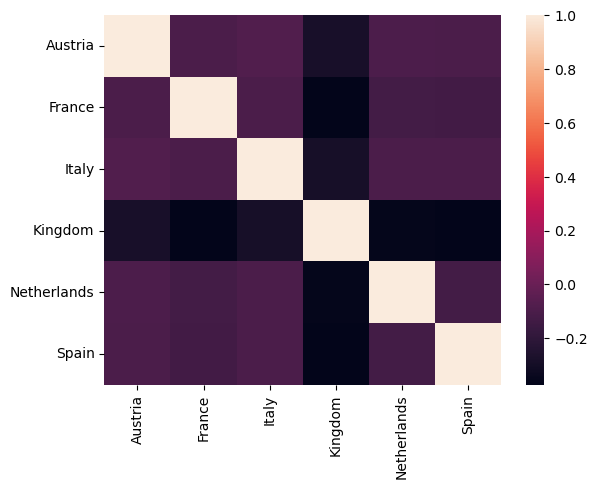

In [108]:
sns.heatmap(train_df[['Austria', 'France',
       'Italy', 'Kingdom', 'Netherlands', 'Spain']].corr())

All of the country variables have the highest correlation with `Kingdom`, the indicator for the United Kingdom. For this reason we will drop this variable to make it the inherent value of the hotel being reviewed.

Next we will look at the days since review variable. 

In [109]:
train_df.columns[0:40]

Index(['Additional_Number_of_Scoring', 'Average_Score',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts', 'lat', 'lng', 'frequent_reviewer',
       'uk_reviewer', 'usa_reviewer', 'Leisure_trip',
       'Submitted_from_a_mobile_device', 'Couple', 'Stayed_1_night',
       'Stayed_2_nights', 'Solo_traveler', 'Stayed_3_nights', 'Business_trip',
       'Group', 'Family_with_young_children', 'Stayed_4_nights', 'Double_Room',
       'Standard_Double_Room', 'Superior_Double_Room', 'Austria', 'France',
       'Italy', 'Kingdom', 'Netherlands', 'Spain', '0-175', '175-350',
       '350-525', '525+', 'p_1', 'p_10', 'p_15', 'p_2', 'p_20', 'p_3'],
      dtype='object')

In [110]:
train_df[['0-175', '175-350', '350-525', '525+']].corr()

,0-175,175-350,350-525,525+
0-175,1.000000,-0.326988,-0.337618,-0.331728
175-350,-0.326988,1.000000,-0.334854,-0.329012
350-525,-0.337618,-0.334854,1.000000,-0.339708
525+,-0.331728,-0.329012,-0.339708,1.000000


<AxesSubplot:>

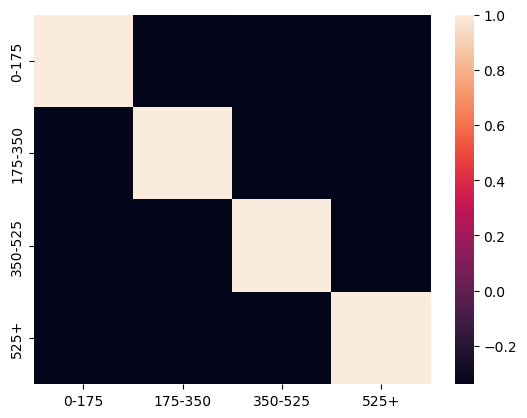

In [111]:
sns.heatmap(train_df[['0-175', '175-350', '350-525', '525+']].corr())

There is little distinction between the correlations, so we will remove the `525+` variable, as it is the largest and least specific. 

In [112]:
train_df = train_df.drop(columns=['Kingdom', '525+'])
test_df = test_df.drop(columns=['Kingdom', '525+'])

Now that we have created training and testing sets ready for modelling, we will export the dataframes as .csv files.

In [113]:
train_df.to_csv('data/Reviews_Train.csv', index=False)
test_df.to_csv('data/Reviews_Test.csv', index=False)

## Conclusion

After feature engineering we now have training and testing sets that are, mostly, ready for modelling. The only issue we have is potential multicollinearity from our encodings. We have combined vectorised versions of the `Positive_Review` and `Negative_Review` values so that we can gain value from the words used in these reviews. This will, hopefully, be useful when beginning to predict whether a review was a `good_review` or not. Within the iterations of vectorising the review data, we saw that though a reduction in accuracy is on the surface negative, if it simplies our data and reduces dimensionality significantly, it is worth the drop. 